In [2]:
import pandas as pd

# Load the dataset to inspect its contents
file_path = '/Users/damonharrington/Downloads/DailyDelhiClimateTest.csv'
data = pd.read_csv(file_path)

# Display the first few rows and the structure of the dataset
data


,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333
...,...,...,...,...,...
109,2017-04-20,34.500000,27.500000,5.562500,998.625000
110,2017-04-21,34.250000,39.375000,6.962500,999.875000
111,2017-04-22,32.900000,40.900000,8.890000,1001.600000
112,2017-04-23,32.875000,27.500000,9.962500,1002.125000


In [3]:
# Convert 'date' column to datetime and set it as the index
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# Normalize the data (between 0 and 1) for LSTM input
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Convert the scaled data back into a DataFrame for easier manipulation
scaled_df = pd.DataFrame(scaled_data, columns=data.columns, index=data.index)
scaled_df.head()


,meantemp,humidity,wind_speed,meanpressure
date,,,,
2017-01-01,0.209066,0.872396,0.075640,0.000000
2017-01-02,0.319149,0.761651,0.084061,0.995298
2017-01-03,0.260047,0.821416,0.146661,0.995356
2017-01-04,0.327660,0.669797,0.176133,0.992624
2017-01-05,0.314421,0.732480,0.106684,0.991206


In [4]:
import numpy as np

# Function to create sequences from time-series data
def create_sequences(data, seq_length=30):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])  # sequence of past days
        y.append(data[i + seq_length, 0])  # target: next day's meantemp
    return np.array(X), np.array(y)

# Create sequences with a sequence length of 30 days
seq_length = 30
X, y = create_sequences(scaled_data, seq_length)

# Check the shapes of X and y to ensure they are correct for LSTM input
X.shape, y.shape


((84, 30, 4), (84,))

In [5]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shapes of the splits
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((67, 30, 4), (17, 30, 4), (67,), (17,))

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))  # optional dropout for regularization
model.add(LSTM(units=50))  # final LSTM layer
model.add(Dense(units=1))  # output layer for regression

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))


Epoch 1/20
5/5 [==============================] - 1s 62ms/step - loss: 0.1318 - val_loss: 0.0580
Epoch 2/20
5/5 [==============================] - 0s 11ms/step - loss: 0.0587 - val_loss: 0.0222
Epoch 3/20
5/5 [==============================] - 0s 11ms/step - loss: 0.0224 - val_loss: 0.0344
Epoch 4/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0314 - val_loss: 0.0158
Epoch 5/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0180 - val_loss: 0.0178
Epoch 6/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0184 - val_loss: 0.0117
Epoch 7/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0139 - val_loss: 0.0140
Epoch 8/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0150 - val_loss: 0.0118
Epoch 9/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0138 - val_loss: 0.0119
Epoch 10/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0124 - val_loss: 0.0144
Epoch 11/20
5/5 [============

In [7]:
# Evaluate the model on test data
test_loss = model.evaluate(X_test, y_test)

# Make predictions
predictions = model.predict(X_test)


1/1 [==============================] - 0s 209ms/step


1/1 [==============================] - 0s 9ms/step


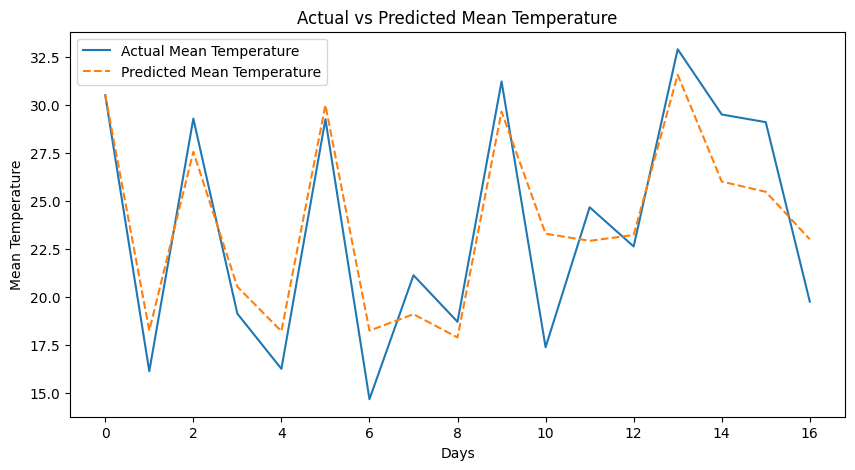

In [8]:
import matplotlib.pyplot as plt

# Make predictions on the test set
predictions = model.predict(X_test)

# Inverse transform the predictions and actual values if you want to bring them back to original scale
y_test_rescaled = scaler.inverse_transform([[i, 0, 0, 0] for i in y_test])[:, 0]
predictions_rescaled = scaler.inverse_transform([[i, 0, 0, 0] for i in predictions.flatten()])[:, 0]

# Plotting actual vs. predicted values
plt.figure(figsize=(10, 5))
plt.plot(y_test_rescaled, label='Actual Mean Temperature')
plt.plot(predictions_rescaled, label='Predicted Mean Temperature', linestyle='--')
plt.xlabel('Days')
plt.ylabel('Mean Temperature')
plt.title('Actual vs Predicted Mean Temperature')
plt.legend()
plt.show()


In [9]:
# Define a modified model with different parameters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Example model with modified LSTM units and dropout
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(units=50))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with more epochs or a lower batch size
history = model.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_test, y_test))


Epoch 1/50
9/9 [==============================] - 1s 33ms/step - loss: 0.1150 - val_loss: 0.0428
Epoch 2/50
9/9 [==============================] - 0s 9ms/step - loss: 0.0331 - val_loss: 0.0162
Epoch 3/50
9/9 [==============================] - 0s 9ms/step - loss: 0.0189 - val_loss: 0.0172
Epoch 4/50
9/9 [==============================] - 0s 10ms/step - loss: 0.0159 - val_loss: 0.0138
Epoch 5/50
9/9 [==============================] - 0s 11ms/step - loss: 0.0179 - val_loss: 0.0137
Epoch 6/50
9/9 [==============================] - 0s 10ms/step - loss: 0.0147 - val_loss: 0.0122
Epoch 7/50
9/9 [==============================] - 0s 10ms/step - loss: 0.0134 - val_loss: 0.0147
Epoch 8/50
9/9 [==============================] - 0s 10ms/step - loss: 0.0132 - val_loss: 0.0151
Epoch 9/50
9/9 [==============================] - 0s 10ms/step - loss: 0.0132 - val_loss: 0.0124
Epoch 10/50
9/9 [==============================] - 0s 10ms/step - loss: 0.0129 - val_loss: 0.0156
Epoch 11/50
9/9 [==============

In [10]:
from tensorflow.keras.layers import Bidirectional

model = Sequential()
model.add(Bidirectional(LSTM(units=100, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(units=50)))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')


In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Inverse transform if necessary to compare on the original scale
y_test_rescaled = scaler.inverse_transform([[i, 0, 0, 0] for i in y_test])[:, 0]
predictions_rescaled = scaler.inverse_transform([[i, 0, 0, 0] for i in predictions.flatten()])[:, 0]

# Calculate MAE and RMSE
mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)
rmse = np.sqrt(mean_squared_error(y_test_rescaled, predictions_rescaled))

print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)


Mean Absolute Error: 2.1127380972677696
Root Mean Squared Error: 2.543000955887385


In [12]:
#The Mean Absolute Error (MAE) of 2.11 and Root Mean Squared Error (RMSE) of 2.54 suggest that the model’s predictions, on average, deviate from the actual mean temperature by around 2.1°C, with larger errors in some cases (indicated by RMSE being higher than MAE).

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Updated sequence length
seq_length = 45

# Re-create the sequences with the new length
X, y = create_sequences(scaled_data, seq_length=seq_length)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the updated model
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))  # Regularization to prevent overfitting
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model with the Adam optimizer and MSE loss
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with additional epochs and possibly a smaller batch size
history = model.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_test, y_test))


Epoch 1/50
7/7 [==============================] - 1s 46ms/step - loss: 0.1520 - val_loss: 0.1080
Epoch 2/50
7/7 [==============================] - 0s 15ms/step - loss: 0.0590 - val_loss: 0.0202
Epoch 3/50
7/7 [==============================] - 0s 12ms/step - loss: 0.0283 - val_loss: 0.0220
Epoch 4/50
7/7 [==============================] - 0s 13ms/step - loss: 0.0211 - val_loss: 0.0102
Epoch 5/50
7/7 [==============================] - 0s 12ms/step - loss: 0.0176 - val_loss: 0.0130
Epoch 6/50
7/7 [==============================] - 0s 12ms/step - loss: 0.0174 - val_loss: 0.0104
Epoch 7/50
7/7 [==============================] - 0s 15ms/step - loss: 0.0152 - val_loss: 0.0108
Epoch 8/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0162 - val_loss: 0.0099
Epoch 9/50
7/7 [==============================] - 0s 13ms/step - loss: 0.0162 - val_loss: 0.0107
Epoch 10/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0160 - val_loss: 0.0096
Epoch 11/50
7/7 [============

In [17]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import load_model

# Example dataset
# X = your features dataset (e.g., numpy array, pandas DataFrame)
# y = your target/labels dataset (e.g., numpy array, pandas DataFrame)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Assuming your model is trained and saved
# model = load_model('path_to_your_model.h5')  # Uncomment if you're loading a pre-trained model

# Predicting on the validation set
y_pred = model.predict(X_val)

# Calculating the RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

# Calculating the MAE (Mean Absolute Error)
mae = mean_absolute_error(y_val, y_pred)

# Output the results
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")


1/1 [==============================] - 0s 16ms/step
RMSE: 0.08297261156287536
MAE: 0.07559017670231308


In [23]:
print(f"y_val: {y_val.shape}, {y_val[:5]}")  # Check the true values (first 5)
print(f"y_pred: {y_pred.shape}, {y_pred[:5]}")  # Check the predicted values (first 5)


y_val: (14,), [0.41641337 0.27963526 0.82978723 0.48355899 0.68617021]
y_pred: (14, 1), [[0.43012762]
 [0.38146466]
 [0.78720576]
 [0.41441113]
 [0.7595382 ]]


In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calculate MAE
mae = mean_absolute_error(y_val, y_pred)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")


MAE: 0.07559017670231308
RMSE: 0.08297261156287536


In [26]:
import numpy as np

# Define a threshold (e.g., 0.05)
threshold = 0.05

# Check how many predictions are within the threshold of the true value
accurate_predictions = np.abs(y_val - y_pred.flatten()) <= threshold

# Calculate accuracy (percentage of predictions within the threshold)
accuracy = np.mean(accurate_predictions)

print(f"Accuracy (within threshold of {threshold}): {accuracy * 100:.2f}%")


Accuracy (within threshold of 0.05): 35.71%


In [32]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Assuming X_train and X_val are in 3D shape (samples, time_steps, features)

# Step 1: Flatten the 3D data to 2D
n_samples, n_time_steps, n_features = X_train.shape
X_train_reshaped = X_train.reshape((n_samples * n_time_steps, n_features))
X_val_reshaped = X_val.reshape((X_val.shape[0] * X_val.shape[1], X_val.shape[2]))

# Step 2: Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_val_scaled = scaler.transform(X_val_reshaped)

# Step 3: Reshape back to 3D for LSTM input
X_train_scaled = X_train_scaled.reshape((n_samples, n_time_steps, n_features))
X_val_scaled = X_val_scaled.reshape((X_val.shape[0], X_val.shape[1], X_val.shape[2]))

print("Scaled X_train shape:", X_train_scaled.shape)
print("Scaled X_val shape:", X_val_scaled.shape)


Scaled X_train shape: (55, 45, 4)
Scaled X_val shape: (14, 45, 4)


In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Define your LSTM model
def create_model(units=50, dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))  # Assuming you're predicting a single value

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

# Instantiate and train the model
model = create_model(units=50, dropout_rate=0.2)

# EarlyStopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_data=(X_val_scaled, y_val), callbacks=[early_stopping])

# Evaluate the model
loss, mae = model.evaluate(X_val_scaled, y_val)
print(f"Validation MAE: {mae}")


Epoch 1/100
2/2 [==============================] - 1s 225ms/step - loss: 0.4221 - mae: 0.6126 - val_loss: 0.2054 - val_mae: 0.4145
Epoch 2/100
2/2 [==============================] - 0s 25ms/step - loss: 0.2948 - mae: 0.4989 - val_loss: 0.1115 - val_mae: 0.2822
Epoch 3/100
2/2 [==============================] - 0s 27ms/step - loss: 0.1784 - mae: 0.3624 - val_loss: 0.0442 - val_mae: 0.1632
Epoch 4/100
2/2 [==============================] - 0s 28ms/step - loss: 0.0765 - mae: 0.2256 - val_loss: 0.0356 - val_mae: 0.1622
Epoch 5/100
2/2 [==============================] - 0s 24ms/step - loss: 0.0412 - mae: 0.1670 - val_loss: 0.0999 - val_mae: 0.2776
Epoch 6/100
2/2 [==============================] - 0s 23ms/step - loss: 0.0784 - mae: 0.2348 - val_loss: 0.0936 - val_mae: 0.2738
Epoch 7/100
2/2 [==============================] - 0s 25ms/step - loss: 0.0645 - mae: 0.2063 - val_loss: 0.0427 - val_mae: 0.1715
Epoch 8/100
2/2 [==============================] - 0s 25ms/step - loss: 0.0332 - mae: 0.1

2/2 [==============================] - 0s 26ms/step - loss: 0.0170 - mae: 0.1120 - val_loss: 0.0085 - val_mae: 0.0849
Epoch 64/100
2/2 [==============================] - 0s 24ms/step - loss: 0.0148 - mae: 0.1043 - val_loss: 0.0084 - val_mae: 0.0857
Epoch 65/100
2/2 [==============================] - 0s 23ms/step - loss: 0.0134 - mae: 0.0950 - val_loss: 0.0084 - val_mae: 0.0857
Epoch 66/100
2/2 [==============================] - 0s 23ms/step - loss: 0.0140 - mae: 0.1006 - val_loss: 0.0084 - val_mae: 0.0853
Epoch 67/100
2/2 [==============================] - 0s 22ms/step - loss: 0.0116 - mae: 0.0897 - val_loss: 0.0086 - val_mae: 0.0843
Epoch 68/100
2/2 [==============================] - 0s 23ms/step - loss: 0.0146 - mae: 0.1011 - val_loss: 0.0086 - val_mae: 0.0832
Epoch 69/100
2/2 [==============================] - 0s 23ms/step - loss: 0.0138 - mae: 0.0976 - val_loss: 0.0082 - val_mae: 0.0833
Epoch 70/100
2/2 [==============================] - 0s 23ms/step - loss: 0.0153 - mae: 0.1065 - 

In [37]:
# Create the model with the best hyperparameters
best_model = KerasLSTMRegressor(units=100, dropout_rate=0.2)

# Train the model on the full training data
best_model.fit(X_train, y_train)

# Predict on the validation set
y_pred = best_model.predict(X_val)

# Evaluate the model
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calculate MAE and RMSE for the validation set
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

print(f"Validation MAE: {mae}")
print(f"Validation RMSE: {rmse}")


Validation MAE: 0.10135073793011154
Validation RMSE: 0.12156375503982081


In [39]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Function to create the model with hyperparameters
def create_model(units=100, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])
    return model

# Set up the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Create the model
model = create_model(units=100, dropout_rate=0.2, learning_rate=0.001)

# Train the model using .fit() directly
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, callbacks=[lr_scheduler])

# Evaluate the model after training
y_pred = model.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

print(f"Validation MAE: {mae}")
print(f"Validation RMSE: {rmse}")


Epoch 1/100
2/2 [==============================] - 1s 254ms/step - loss: 0.2157 - mae: 0.4200 - val_loss: 0.0300 - val_mae: 0.1476 - lr: 0.0010
Epoch 2/100
2/2 [==============================] - 0s 39ms/step - loss: 0.0517 - mae: 0.1867 - val_loss: 0.1277 - val_mae: 0.3309 - lr: 0.0010
Epoch 3/100
2/2 [==============================] - 0s 38ms/step - loss: 0.0778 - mae: 0.2295 - val_loss: 0.0391 - val_mae: 0.1696 - lr: 0.0010
Epoch 4/100
2/2 [==============================] - 0s 40ms/step - loss: 0.0358 - mae: 0.1617 - val_loss: 0.0187 - val_mae: 0.1211 - lr: 0.0010
Epoch 5/100
2/2 [==============================] - 0s 50ms/step - loss: 0.0506 - mae: 0.1916 - val_loss: 0.0258 - val_mae: 0.1269 - lr: 0.0010
Epoch 6/100
2/2 [==============================] - 0s 58ms/step - loss: 0.0516 - mae: 0.1890 - val_loss: 0.0187 - val_mae: 0.1158 - lr: 0.0010
Epoch 7/100
2/2 [==============================] - 0s 43ms/step - loss: 0.0325 - mae: 0.1554 - val_loss: 0.0124 - val_mae: 0.1036 - lr: 0.001

2/2 [==============================] - 0s 41ms/step - loss: 0.0132 - mae: 0.0985 - val_loss: 0.0088 - val_mae: 0.0838 - lr: 2.5000e-04
Epoch 58/100
2/2 [==============================] - 0s 39ms/step - loss: 0.0151 - mae: 0.1005 - val_loss: 0.0086 - val_mae: 0.0836 - lr: 2.5000e-04
Epoch 59/100
2/2 [==============================] - 0s 41ms/step - loss: 0.0117 - mae: 0.0923 - val_loss: 0.0086 - val_mae: 0.0831 - lr: 2.5000e-04
Epoch 60/100
2/2 [==============================] - 0s 53ms/step - loss: 0.0156 - mae: 0.1057 - val_loss: 0.0087 - val_mae: 0.0829 - lr: 1.2500e-04
Epoch 61/100
2/2 [==============================] - 0s 41ms/step - loss: 0.0132 - mae: 0.0893 - val_loss: 0.0088 - val_mae: 0.0828 - lr: 1.2500e-04
Epoch 62/100
2/2 [==============================] - 0s 40ms/step - loss: 0.0138 - mae: 0.0928 - val_loss: 0.0088 - val_mae: 0.0827 - lr: 1.2500e-04
Epoch 63/100
2/2 [==============================] - 0s 40ms/step - loss: 0.0152 - mae: 0.1066 - val_loss: 0.0088 - val_mae: 0

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Assuming you already have the model defined as `best_model`
# If you're using a custom model definition, you can define the model like this:

best_model = Sequential()
best_model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
best_model.add(LSTM(units=50))
best_model.add(Dense(1))

best_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Fit the model with validation data
history = best_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, 
                         batch_size=32, callbacks=[early_stopping, lr_scheduler])

# After fitting, you can evaluate the model or make predictions
y_pred = best_model.predict(X_val)


Epoch 1/100
2/2 [==============================] - 1s 314ms/step - loss: 0.4224 - mae: 0.6034 - val_loss: 0.0671 - val_mae: 0.1895 - lr: 0.0010
Epoch 2/100
2/2 [==============================] - 0s 44ms/step - loss: 0.0916 - mae: 0.2439 - val_loss: 0.0913 - val_mae: 0.2623 - lr: 0.0010
Epoch 3/100
2/2 [==============================] - 0s 40ms/step - loss: 0.0754 - mae: 0.2149 - val_loss: 0.1398 - val_mae: 0.3352 - lr: 0.0010
Epoch 4/100
2/2 [==============================] - 0s 47ms/step - loss: 0.0847 - mae: 0.2319 - val_loss: 0.0597 - val_mae: 0.2145 - lr: 0.0010
Epoch 5/100
2/2 [==============================] - 0s 46ms/step - loss: 0.0421 - mae: 0.1694 - val_loss: 0.0251 - val_mae: 0.1350 - lr: 0.0010
Epoch 6/100
2/2 [==============================] - 0s 56ms/step - loss: 0.0421 - mae: 0.1774 - val_loss: 0.0267 - val_mae: 0.1378 - lr: 0.0010
Epoch 7/100
2/2 [==============================] - 0s 39ms/step - loss: 0.0526 - mae: 0.1950 - val_loss: 0.0247 - val_mae: 0.1331 - lr: 0.001

In [49]:
y_pred

array([0.31490687], dtype=float32)

In [47]:
y_val

array([0.41641337, 0.27963526, 0.82978723, 0.48355899, 0.68617021,
       0.37234043, 0.34042553, 0.5248227 , 0.83510638, 0.37765957,
       0.58265139, 0.34574468, 0.86052009, 0.52659574])

In [51]:
df = pd.DataFrame({'y_actual': list(y_val), 'y_pred':list(y_pred)})

In [58]:
df

,y_actual,y_pred
0,0.416413,[0.5234362]
1,0.279635,[0.31490687]
2,0.829787,[0.763256]
3,0.483559,[0.34533134]
4,0.686170,[0.8265874]
5,0.372340,[0.5021764]
6,0.340426,[0.42511326]
7,0.524823,[0.51229805]
8,0.835106,[0.7066375]
9,0.377660,[0.44238538]


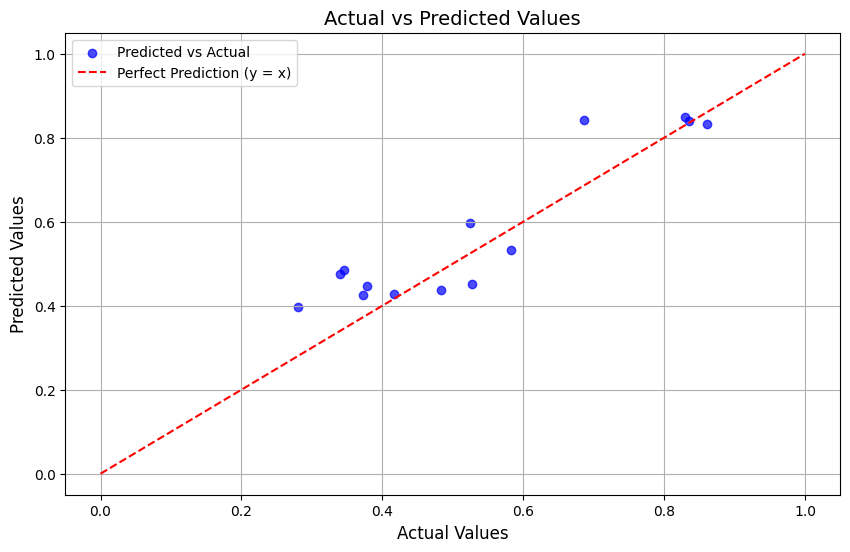

In [70]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
actual = y_actual
pred = y_pred

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_actual, y_pred, color='blue', label='Predicted vs Actual', alpha=0.7)

# Add a perfect prediction line (y=x)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label="Perfect Prediction (y = x)")

# Add titles and labels
plt.title('Actual vs Predicted Values', fontsize=14)
plt.xlabel('Actual Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.legend()

# Show grid and plot
plt.grid(True)
plt.show()


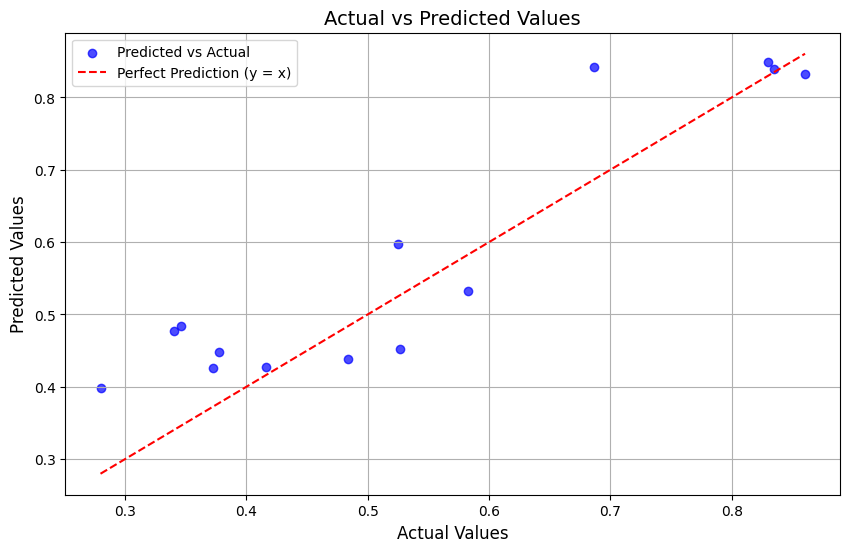

In [71]:
import matplotlib.pyplot as plt
import numpy as np

# Full y_actual and y_pred data
actual = y_actual
pred = y_pred

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_actual, y_pred, color='blue', label='Predicted vs Actual', alpha=0.7)

# Add a perfect prediction line (y=x)
plt.plot([min(y_actual), max(y_actual)], [min(y_actual), max(y_actual)], color='red', linestyle='--', label="Perfect Prediction (y = x)")

# Add titles and labels
plt.title('Actual vs Predicted Values', fontsize=14)
plt.xlabel('Actual Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.legend()

# Show grid and plot
plt.grid(True)
plt.show()


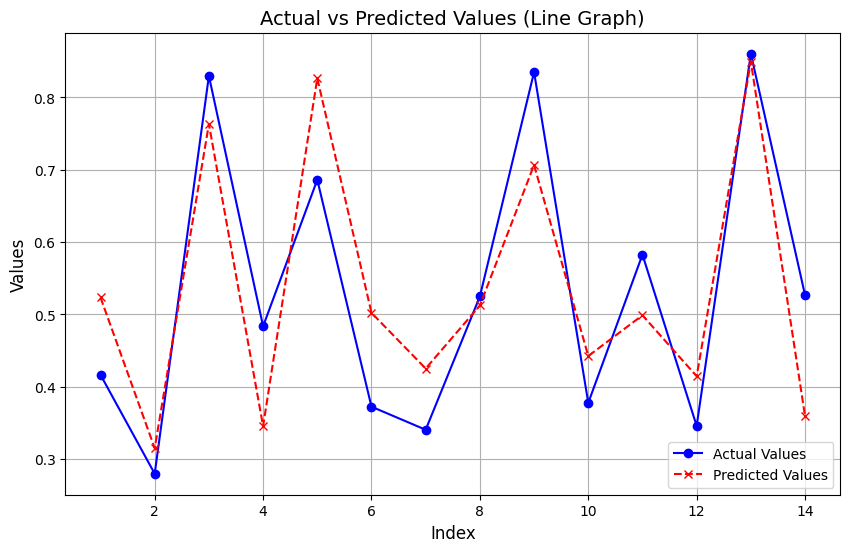

In [61]:
import matplotlib.pyplot as plt
import numpy as np

# Full y_actual and y_pred data
y_actual = [
    0.416413, 0.279635, 0.829787, 0.483559, 0.686170, 0.372340, 0.340426, 0.524823,
    0.835106, 0.377660, 0.582651, 0.345745, 0.860520, 0.526596
]
y_pred = [
    0.5234362, 0.31490687, 0.763256, 0.34533134, 0.8265874, 0.5021764, 0.42511326,
    0.51229805, 0.7066375, 0.44238538, 0.4988049, 0.4144284, 0.84960055, 0.3591958
]

# Generate an index array (for the x-axis)
x = np.arange(1, len(y_actual) + 1)

# Create a line plot for Actual and Predicted values
plt.figure(figsize=(10, 6))
plt.plot(x, y_actual, label='Actual Values', color='blue', marker='o', linestyle='-', markersize=6)
plt.plot(x, y_pred, label='Predicted Values', color='red', marker='x', linestyle='--', markersize=6)

# Add titles and labels
plt.title('Actual vs Predicted Values (Line Graph)', fontsize=14)
plt.xlabel('Index', fontsize=12)
plt.ylabel('Values', fontsize=12)

# Display legend
plt.legend()

# Display grid
plt.grid(True)

# Show plot
plt.show()


In [62]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Flatten y_pred array if it has shape (n, 1)
y_pred_flat = np.array(y_pred).flatten()

# Calculate MAE, RMSE, and R-squared
mae = mean_absolute_error(y_actual, y_pred_flat)
rmse = mean_squared_error(y_actual, y_pred_flat, squared=False)  # RMSE
r2 = r2_score(y_actual, y_pred_flat)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")


Mean Absolute Error (MAE): 0.08846876928571426
Root Mean Squared Error (RMSE): 0.10025604472180558
R-squared (R²): 0.7267488032158962


In [63]:
tolerance = 0.1  # 10% tolerance

# Calculate "accuracy" as percentage of predictions within tolerance
accurate_predictions = np.mean(np.abs(y_actual - y_pred_flat) / y_actual < tolerance) * 100
print(f"Custom Accuracy (within {tolerance*100}% tolerance): {accurate_predictions}%")


Custom Accuracy (within 10.0% tolerance): 21.428571428571427%


In [64]:
!pip install keras-tuner



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [65]:
pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.4 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.2
    Uninstalling pip-24.2:
      Successfully uninstalled pip-24.2
Note: you may need to restart the kernel to use updated packages.


In [66]:
from keras_tuner import RandomSearch
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

# Define a model-building function for Keras Tuner
def build_model(hp):
    model = Sequential()
    model.add(LSTM(
        units=hp.Int('units', min_value=50, max_value=200, step=50),
        return_sequences=True,
        input_shape=(X_train.shape[1], X_train.shape[2])
    ))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(LSTM(units=hp.Int('units2', min_value=50, max_value=200, step=50)))
    model.add(Dense(1))
    
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-3, 1e-4, 1e-5])),
                  loss='mse',
                  metrics=['mae'])
    return model

# Run the tuning process
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=2,
    directory='my_dir',
    project_name='lstm_tuning'
)

tuner.search(X_train, y_train, epochs=50, validation_data=(X_val, y_val), batch_size=32)

# Retrieve the best model
best_hyperparams = tuner.get_best_hyperparameters(1)[0]
best_model = tuner.hypermodel.build(best_hyperparams)


Trial 10 Complete [00h 00m 10s]
val_loss: 0.1933029145002365

Best val_loss So Far: 0.008089868584647775
Total elapsed time: 00h 02m 05s


In [67]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predict on test set
y_test_pred = best_model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_test_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2 = r2_score(y_test, y_test_pred)

# Custom accuracy within a 10% tolerance
def custom_accuracy(y_true, y_pred, tolerance=0.1):
    correct = np.abs((y_pred - y_true) / y_true) <= tolerance
    accuracy = np.mean(correct) * 100
    return accuracy

custom_acc = custom_accuracy(y_test, y_test_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")
print(f"Custom Accuracy (within 10% tolerance): {custom_acc}%")


1/1 [==============================] - 0s 255ms/step
Mean Absolute Error (MAE): 0.6195847920164308
Root Mean Squared Error (RMSE): 0.6482911022180072
R-squared (R²): -10.425639994895194
Custom Accuracy (within 10% tolerance): 0.0%


In [69]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Assuming X_train, y_train, X_val, y_val are already prepared and scaled

# Define the model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, kernel_regularizer=l2(0.001), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))  # Increased dropout
model.add(LSTM(units=50, kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(1))

# Compile the model with a lower learning rate
optimizer = Adam(learning_rate=0.0005)  # Reduced learning rate
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Set up callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=16,  # Try a smaller batch size
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

# Evaluate on the test set
y_pred = model.predict(X_test)

# Compute metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Custom Accuracy (within 10% tolerance)
tolerance = 0.10
accuracy = np.mean(np.abs((y_test - y_pred.flatten()) / y_test) <= tolerance) * 100

# Display results
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R²):", r2)
print("Custom Accuracy (within 10% tolerance):", accuracy, "%")


Epoch 1/100
4/4 [==============================] - 1s 113ms/step - loss: 0.2799 - mae: 0.3705 - val_loss: 0.1202 - val_mae: 0.1494 - lr: 5.0000e-04
Epoch 2/100
4/4 [==============================] - 0s 23ms/step - loss: 0.1568 - mae: 0.2236 - val_loss: 0.1552 - val_mae: 0.2299 - lr: 5.0000e-04
Epoch 3/100
4/4 [==============================] - 0s 18ms/step - loss: 0.1678 - mae: 0.2373 - val_loss: 0.1355 - val_mae: 0.1984 - lr: 5.0000e-04
Epoch 4/100
4/4 [==============================] - 0s 18ms/step - loss: 0.1410 - mae: 0.1920 - val_loss: 0.1085 - val_mae: 0.1334 - lr: 5.0000e-04
Epoch 5/100
4/4 [==============================] - 0s 19ms/step - loss: 0.1474 - mae: 0.2078 - val_loss: 0.1040 - val_mae: 0.1265 - lr: 5.0000e-04
Epoch 6/100
4/4 [==============================] - 0s 17ms/step - loss: 0.1305 - mae: 0.1838 - val_loss: 0.0998 - val_mae: 0.1164 - lr: 5.0000e-04
Epoch 7/100
4/4 [==============================] - 0s 21ms/step - loss: 0.1218 - mae: 0.1668 - val_loss: 0.0999 - val

4/4 [==============================] - 0s 17ms/step - loss: 0.0549 - mae: 0.1047 - val_loss: 0.0454 - val_mae: 0.0751 - lr: 5.0000e-04
Epoch 57/100
4/4 [==============================] - 0s 17ms/step - loss: 0.0585 - mae: 0.1199 - val_loss: 0.0456 - val_mae: 0.0804 - lr: 5.0000e-04
Epoch 58/100
4/4 [==============================] - 0s 17ms/step - loss: 0.0611 - mae: 0.1275 - val_loss: 0.0443 - val_mae: 0.0736 - lr: 5.0000e-04
Epoch 59/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0587 - mae: 0.1200 - val_loss: 0.0454 - val_mae: 0.0756 - lr: 5.0000e-04
Epoch 60/100
4/4 [==============================] - 0s 17ms/step - loss: 0.0558 - mae: 0.1152 - val_loss: 0.0434 - val_mae: 0.0763 - lr: 5.0000e-04
Epoch 61/100
4/4 [==============================] - 0s 18ms/step - loss: 0.0513 - mae: 0.1009 - val_loss: 0.0428 - val_mae: 0.0793 - lr: 5.0000e-04
Epoch 62/100
4/4 [==============================] - 0s 17ms/step - loss: 0.0594 - mae: 0.1293 - val_loss: 0.0421 - val_mae: 0